# Import Library

In [1]:
!pip install tweet-preprocessor
!pip install PySastrawi
!pip install nlp-id

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.6/210.6 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.8/54.8 MB 9.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.5/320.5 kB 29.9 MB/s eta 0:00:00
  Created wheel for nlp-id: filename=nlp_id-0.1.15.0-py3-none-any.whl size=58153891 sha256=98ac694dfe2c6ee3029df44c90dca3d9d12fd10355028c1ff868b9d647a460ba
  Stored in directory: /root/.cache/pip/wheels/85/34/2a/deaf7b7896a1eed336b874e1a7732588d40bb7bdc0a824e73e
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=e79c8a8835790780dc9757d703d092f4d9c5086fc5045c4bf16c7531b49a8da5
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built nlp-id wget
  Attempting uninstall: pytest
    Found existing installation: pytest 7.4.4
    Uninstalling pytest-7.4.4:
      Successfully un

In [52]:
import numpy as np
import pandas as pd
from scipy.sparse import vstack
import json
import joblib
import string
import re
import csv
import nltk
import matplotlib.pyplot as plt
import preprocessor as p
import seaborn as sns

from wordcloud import WordCloud
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nlp_id.tokenizer import Tokenizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, classification_report

nltk.download('punkt')
tokenizer = Tokenizer()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Import Data

In [4]:
df = pd.read_excel("/content/rohingya.xlsx")
df.head()

,created_at,id_str,full_text,quote_count,reply_count,retweet_count,favorite_count,lang,user_id_str,conversation_id_str,username,tweet_url
0,Wed Feb 07 18:15:49 +0000 2024,1755290000000000000,@markieefiance Mereka ini emang sampah negara ...,0,0,0,0,in,1571050000000000000,1755150000000000000,xovrniccc,https://twitter.com/xovrniccc/status/175529430...
1,Wed Feb 07 18:07:12 +0000 2024,1755290000000000000,@RodriChen geli baca tulisan di bawahnya Buka...,0,0,0,0,in,3193742610,1755090000000000000,echoPiR,https://twitter.com/echoPiR/status/17552921376...
2,Wed Feb 07 17:58:01 +0000 2024,1755290000000000000,@roseeunjennie @bahyrm @ferrykoto Dari jaman s...,0,0,0,0,in,1470800000000000000,1755180000000000000,BTrisudewo,https://twitter.com/BTrisudewo/status/17552898...
3,Wed Feb 07 17:24:59 +0000 2024,1755280000000000000,Jdi presiden rohingya aja lebih cocok,0,0,0,0,in,1680350000000000000,1755280000000000000,81_habibie95625,https://twitter.com/81_habibie95625/status/175...
4,Wed Feb 07 17:23:22 +0000 2024,1755280000000000000,Anjeng banget â€œbukan memasak untuk rohingyaâ...,0,0,0,0,in,1239120000000000000,1755280000000000000,ghrrffdd,https://twitter.com/ghrrffdd/status/1755281110...


# Preprocessing

In [5]:
stemfactory = StemmerFactory()
stemmer = stemfactory.create_stemmer()

In [6]:
pattern = r'[0-9]'
def preprocessing(text):
    for punctuation in string.punctuation:
        text = p.clean(text) #menghapus tag, hashtag
        text = re.sub(r'http[s]?://\S+','',text) #menghapus URL
        text = text.replace(punctuation, '') #menghapus tanda baca
        text = re.sub(pattern, '', text)#menghapus angka
        text = re.sub(r'\r?\n|\r','',text)#menghapus baris baru
        text = text.encode('ascii', 'ignore').decode('ascii') #menghapus emoji
        text = text.lower() #mengubah ke huruf kecil (case folding)
        text = stemmer.stem(text)
    return text

In [7]:
df['full_text'] = df['full_text'].astype(str)
df['processed'] = df['full_text'].apply(preprocessing)
df.head(10)

,created_at,id_str,full_text,quote_count,reply_count,retweet_count,favorite_count,lang,user_id_str,conversation_id_str,username,tweet_url,processed
0,Wed Feb 07 18:15:49 +0000 2024,1755290000000000000,@markieefiance Mereka ini emang sampah negara ...,0,0,0,0,in,1571050000000000000,1755150000000000000,xovrniccc,https://twitter.com/xovrniccc/status/175529430...,mereka ini emang sampah negara yang pantas unt...
1,Wed Feb 07 18:07:12 +0000 2024,1755290000000000000,@RodriChen geli baca tulisan di bawahnya Buka...,0,0,0,0,in,3193742610,1755090000000000000,echoPiR,https://twitter.com/echoPiR/status/17552921376...,geli baca tulis di bawah bukan masak untuk roh...
2,Wed Feb 07 17:58:01 +0000 2024,1755290000000000000,@roseeunjennie @bahyrm @ferrykoto Dari jaman s...,0,0,0,0,in,1470800000000000000,1755180000000000000,BTrisudewo,https://twitter.com/BTrisudewo/status/17552898...,dari jaman suharto juga tol ya bayar tolol kal...
3,Wed Feb 07 17:24:59 +0000 2024,1755280000000000000,Jdi presiden rohingya aja lebih cocok,0,0,0,0,in,1680350000000000000,1755280000000000000,81_habibie95625,https://twitter.com/81_habibie95625/status/175...,jdi presiden rohingya aja lebih cocok
4,Wed Feb 07 17:23:22 +0000 2024,1755280000000000000,Anjeng banget â€œbukan memasak untuk rohingyaâ...,0,0,0,0,in,1239120000000000000,1755280000000000000,ghrrffdd,https://twitter.com/ghrrffdd/status/1755281110...,anjeng banget bukan masak untuk rohingya ktl kau
5,Wed Feb 07 17:01:43 +0000 2024,1755280000000000000,Narasi mending duitnya kasih ke rakyat papua d...,0,0,0,0,in,1003870000000000000,1755280000000000000,lamiapd,https://twitter.com/lamiapd/status/17552756601...,narasi mending duit kasih ke rakyat papua dari...
6,Wed Feb 07 16:39:44 +0000 2024,1755270000000000000,Baru aku tau ada rohingya di siam,0,1,0,0,in,618552928,1755270000000000000,aafifawis,https://twitter.com/aafifawis/status/175527012...,baru aku tau ada rohingya di siam
7,Wed Feb 07 16:18:00 +0000 2024,1755260000000000000,@utdfocusid @bliblidotcom Rohingya kok dilindungi,0,0,0,0,in,1294520000000000000,1755230000000000000,Rf23476183,https://twitter.com/Rf23476183/status/17552646...,rohingya kok lindung
8,Wed Feb 07 16:12:47 +0000 2024,1755260000000000000,"@yozariam Orang orang makin gila dekat epmilu,...",0,0,0,0,in,1678420000000000000,1755100000000000000,XRenSteve,https://twitter.com/XRenSteve/status/175526334...,orang orang makin gila dekat epmilu semua kait...
9,Wed Feb 07 16:11:05 +0000 2024,1755260000000000000,"@zy_zy_its_me Disegani dunia ? Bangun hey, tid...",0,1,0,0,in,1707050000000000000,1755070000000000000,Newbie_Frontale,https://twitter.com/Newbie_Frontale/status/175...,segani dunia bangun hey tidur laku miring kasu...


**Normalisasi**

In [9]:
with open('combined_slang_words.txt') as f:
    data = f.read()
dict_slang = json.loads(data)

# Fungsi untuk mengganti kata-kata dalam kalimat dengan value dari dictionary
def ganti_kata(kalimat, dictionary):
    kata_terpisah = kalimat.split()
    kata_baru = [dictionary.get(kata, kata) for kata in kata_terpisah]
    return " ".join(kata_baru)

# Menyamakan kata dalam kolom 'kalimat' dengan key pada dictionary dan mengganti dengan value pada dictionary
df['processed'] = df['processed'].apply(lambda x: ganti_kata(x, dict_slang))


In [10]:
df.head(10)

,created_at,id_str,full_text,quote_count,reply_count,retweet_count,favorite_count,lang,user_id_str,conversation_id_str,username,tweet_url,processed
0,Wed Feb 07 18:15:49 +0000 2024,1755290000000000000,@markieefiance Mereka ini emang sampah negara ...,0,0,0,0,in,1571050000000000000,1755150000000000000,xovrniccc,https://twitter.com/xovrniccc/status/175529430...,mereka ini emang sampah negara yang pantas unt...
1,Wed Feb 07 18:07:12 +0000 2024,1755290000000000000,@RodriChen geli baca tulisan di bawahnya Buka...,0,0,0,0,in,3193742610,1755090000000000000,echoPiR,https://twitter.com/echoPiR/status/17552921376...,geli baca tulis di bawah bukan masak untuk roh...
2,Wed Feb 07 17:58:01 +0000 2024,1755290000000000000,@roseeunjennie @bahyrm @ferrykoto Dari jaman s...,0,0,0,0,in,1470800000000000000,1755180000000000000,BTrisudewo,https://twitter.com/BTrisudewo/status/17552898...,dari jaman suharto juga tol iya bayar tolol ka...
3,Wed Feb 07 17:24:59 +0000 2024,1755280000000000000,Jdi presiden rohingya aja lebih cocok,0,0,0,0,in,1680350000000000000,1755280000000000000,81_habibie95625,https://twitter.com/81_habibie95625/status/175...,jadi presiden rohingya saja lebih cocok
4,Wed Feb 07 17:23:22 +0000 2024,1755280000000000000,Anjeng banget â€œbukan memasak untuk rohingyaâ...,0,0,0,0,in,1239120000000000000,1755280000000000000,ghrrffdd,https://twitter.com/ghrrffdd/status/1755281110...,anjeng banget bukan masak untuk rohingya ktl kamu
5,Wed Feb 07 17:01:43 +0000 2024,1755280000000000000,Narasi mending duitnya kasih ke rakyat papua d...,0,0,0,0,in,1003870000000000000,1755280000000000000,lamiapd,https://twitter.com/lamiapd/status/17552756601...,narasi lebih baik duit kasih ke rakyat papua d...
6,Wed Feb 07 16:39:44 +0000 2024,1755270000000000000,Baru aku tau ada rohingya di siam,0,1,0,0,in,618552928,1755270000000000000,aafifawis,https://twitter.com/aafifawis/status/175527012...,baru aku tahu ada rohingya di siam
7,Wed Feb 07 16:18:00 +0000 2024,1755260000000000000,@utdfocusid @bliblidotcom Rohingya kok dilindungi,0,0,0,0,in,1294520000000000000,1755230000000000000,Rf23476183,https://twitter.com/Rf23476183/status/17552646...,rohingya kok lindung
8,Wed Feb 07 16:12:47 +0000 2024,1755260000000000000,"@yozariam Orang orang makin gila dekat epmilu,...",0,0,0,0,in,1678420000000000000,1755100000000000000,XRenSteve,https://twitter.com/XRenSteve/status/175526334...,orang orang makin gila dekat epmilu semua kait...
9,Wed Feb 07 16:11:05 +0000 2024,1755260000000000000,"@zy_zy_its_me Disegani dunia ? Bangun hey, tid...",0,1,0,0,in,1707050000000000000,1755070000000000000,Newbie_Frontale,https://twitter.com/Newbie_Frontale/status/175...,segani dunia bangun hai tidur laku miring kasu...


**Stopword Removal**

In [11]:
factory = StopWordRemoverFactory()
stopword = factory.create_stop_word_remover()

In [12]:
def stopWord(text):
  for punctuation in string.punctuation:
    text = stopword.remove(text)
  return text

In [13]:
df['processed'] = df['processed'].astype(str)
df['processed'] = df['processed'].apply(stopWord)
df.head(10)

,created_at,id_str,full_text,quote_count,reply_count,retweet_count,favorite_count,lang,user_id_str,conversation_id_str,username,tweet_url,processed
0,Wed Feb 07 18:15:49 +0000 2024,1755290000000000000,@markieefiance Mereka ini emang sampah negara ...,0,0,0,0,in,1571050000000000000,1755150000000000000,xovrniccc,https://twitter.com/xovrniccc/status/175529430...,emang sampah negara binasa kayak ungsi rohingy...
1,Wed Feb 07 18:07:12 +0000 2024,1755290000000000000,@RodriChen geli baca tulisan di bawahnya Buka...,0,0,0,0,in,3193742610,1755090000000000000,echoPiR,https://twitter.com/echoPiR/status/17552921376...,geli baca tulis masak rohingya peduli ungsi pe...
2,Wed Feb 07 17:58:01 +0000 2024,1755290000000000000,@roseeunjennie @bahyrm @ferrykoto Dari jaman s...,0,0,0,0,in,1470800000000000000,1755180000000000000,BTrisudewo,https://twitter.com/BTrisudewo/status/17552898...,jaman suharto tol iya bayar tolol gratis iya n...
3,Wed Feb 07 17:24:59 +0000 2024,1755280000000000000,Jdi presiden rohingya aja lebih cocok,0,0,0,0,in,1680350000000000000,1755280000000000000,81_habibie95625,https://twitter.com/81_habibie95625/status/175...,presiden rohingya cocok
4,Wed Feb 07 17:23:22 +0000 2024,1755280000000000000,Anjeng banget â€œbukan memasak untuk rohingyaâ...,0,0,0,0,in,1239120000000000000,1755280000000000000,ghrrffdd,https://twitter.com/ghrrffdd/status/1755281110...,anjeng banget masak rohingya ktl
5,Wed Feb 07 17:01:43 +0000 2024,1755280000000000000,Narasi mending duitnya kasih ke rakyat papua d...,0,0,0,0,in,1003870000000000000,1755280000000000000,lamiapd,https://twitter.com/lamiapd/status/17552756601...,narasi duit kasih rakyat papua rohingya ras be...
6,Wed Feb 07 16:39:44 +0000 2024,1755270000000000000,Baru aku tau ada rohingya di siam,0,1,0,0,in,618552928,1755270000000000000,aafifawis,https://twitter.com/aafifawis/status/175527012...,rohingya siam
7,Wed Feb 07 16:18:00 +0000 2024,1755260000000000000,@utdfocusid @bliblidotcom Rohingya kok dilindungi,0,0,0,0,in,1294520000000000000,1755230000000000000,Rf23476183,https://twitter.com/Rf23476183/status/17552646...,rohingya lindung
8,Wed Feb 07 16:12:47 +0000 2024,1755260000000000000,"@yozariam Orang orang makin gila dekat epmilu,...",0,0,0,0,in,1678420000000000000,1755100000000000000,XRenSteve,https://twitter.com/XRenSteve/status/175526334...,gila epmilu kait kait milu reaksi rohingya mak...
9,Wed Feb 07 16:11:05 +0000 2024,1755260000000000000,"@zy_zy_its_me Disegani dunia ? Bangun hey, tid...",0,1,0,0,in,1707050000000000000,1755070000000000000,Newbie_Frontale,https://twitter.com/Newbie_Frontale/status/175...,segani dunia bangun tidur miring laut cina sel...


**Labeling dengan Inset**

In [14]:
!git clone https://github.com/fajri91/InSet.git

Cloning into 'InSet'...
remote: Enumerating objects: 16, done.
remote: Total 16 (delta 0), reused 0 (delta 0), pack-reused 16
Receiving objects: 100% (16/16), 49.18 KiB | 2.24 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [15]:
# Load lexicon
positive_lexicon = pd.read_csv("/content/InSet/positive.tsv", sep="\t")
negative_lexicon = pd.read_csv("/content/InSet/negative.tsv", sep="\t")
lexicon = pd.concat([positive_lexicon, negative_lexicon])

In [32]:
df['weight'] = df['processed'].apply(lambda x: sum(lexicon[lexicon['word'].isin(str(x).split())]['weight']))

In [33]:
df['label'] = df['weight'].apply(lambda x: 'netral' if x == 0 else ('negatif' if x < 0 else 'positif'))

In [34]:
df.head()

,created_at,id_str,full_text,quote_count,reply_count,retweet_count,favorite_count,lang,user_id_str,conversation_id_str,username,tweet_url,processed,weight,label
0,Wed Feb 07 18:15:49 +0000 2024,1755290000000000000,@markieefiance Mereka ini emang sampah negara ...,0,0,0,0,in,1571050000000000000,1755150000000000000,xovrniccc,https://twitter.com/xovrniccc/status/175529430...,emang sampah negara binasa kayak ungsi rohingy...,-17,negatif
1,Wed Feb 07 18:07:12 +0000 2024,1755290000000000000,@RodriChen geli baca tulisan di bawahnya Buka...,0,0,0,0,in,3193742610,1755090000000000000,echoPiR,https://twitter.com/echoPiR/status/17552921376...,geli baca tulis masak rohingya peduli ungsi pe...,2,positif
2,Wed Feb 07 17:58:01 +0000 2024,1755290000000000000,@roseeunjennie @bahyrm @ferrykoto Dari jaman s...,0,0,0,0,in,1470800000000000000,1755180000000000000,BTrisudewo,https://twitter.com/BTrisudewo/status/17552898...,jaman suharto tol iya bayar tolol gratis iya n...,-22,negatif
3,Wed Feb 07 17:24:59 +0000 2024,1755280000000000000,Jdi presiden rohingya aja lebih cocok,0,0,0,0,in,1680350000000000000,1755280000000000000,81_habibie95625,https://twitter.com/81_habibie95625/status/175...,presiden rohingya cocok,4,positif
4,Wed Feb 07 17:23:22 +0000 2024,1755280000000000000,Anjeng banget â€œbukan memasak untuk rohingyaâ...,0,0,0,0,in,1239120000000000000,1755280000000000000,ghrrffdd,https://twitter.com/ghrrffdd/status/1755281110...,anjeng banget masak rohingya ktl,-4,negatif


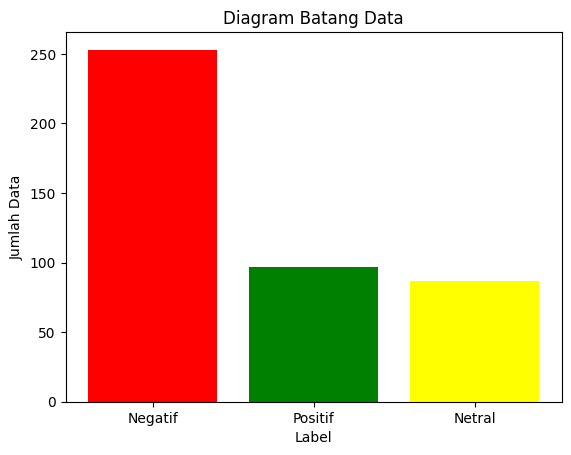

In [41]:
# Visualisasi dengan diagram batang
# Hitung frekuensi setiap kategori label
label_counts = df['label'].value_counts()

# Buat diagram batang
plt.bar(['Negatif', 'Positif', 'Netral'], label_counts, color=['red', 'green', 'yellow'])

# Tambahkan label dan judul
plt.xlabel('Label')
plt.ylabel('Jumlah Data')
plt.title('Diagram Batang Data')

# Tampilkan diagram
plt.show()

**Visualisasi**

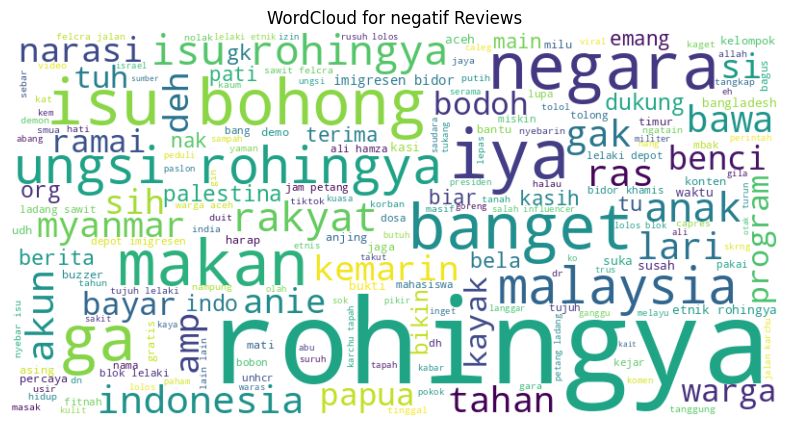

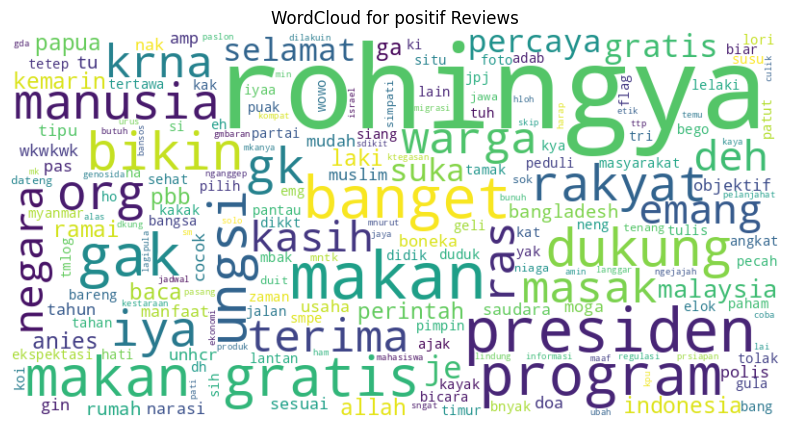

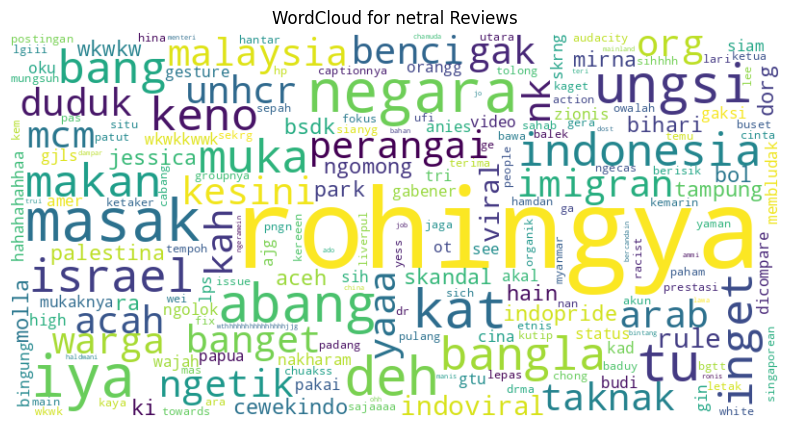

In [42]:
def show_wordcloud(data, label):
    # Konversi nilai ke string menggunakan str()
    words = ' '.join(str(text) for text in df[df['label'] == label]['processed'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(words)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'WordCloud for {label} Reviews')
    plt.show()

# Panggil fungsi show_wordcloud untuk setiap label
unique_labels = df['label'].unique()
for label in unique_labels:
    show_wordcloud(data, label)

**Split Dataset**

In [43]:
# Bagi data menjadi data training dan data testing
X_train, X_test, y_train, y_test = train_test_split(df['processed'], df['label'], test_size=0.2, random_state=42, stratify=df['label'])

print('Train Dataset:')
print(len(y_train))
print(y_train.value_counts())
print('\n')

print('Validation Dataset:')
print(len(y_test))
print(y_test.value_counts())
print('\n')

Train Dataset:
349
negatif    202
positif     77
netral      70
Name: label, dtype: int64


Validation Dataset:
88
negatif    51
positif    20
netral     17
Name: label, dtype: int64




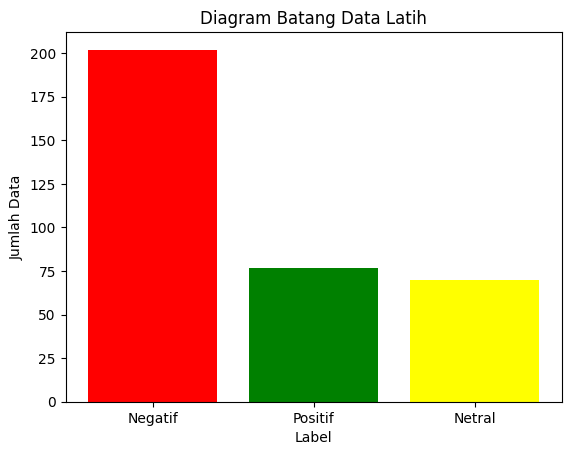

In [44]:
# Visualisasi dengan diagram batang
# Hitung frekuensi setiap kategori label
label_counts = y_train.value_counts()

# Buat diagram batang
plt.bar(['Negatif', 'Positif', 'Netral'], label_counts, color=['red', 'green', 'yellow'])

# Tambahkan label dan judul
plt.xlabel('Label')
plt.ylabel('Jumlah Data')
plt.title('Diagram Batang Data Latih')

# Tampilkan diagram
plt.show()

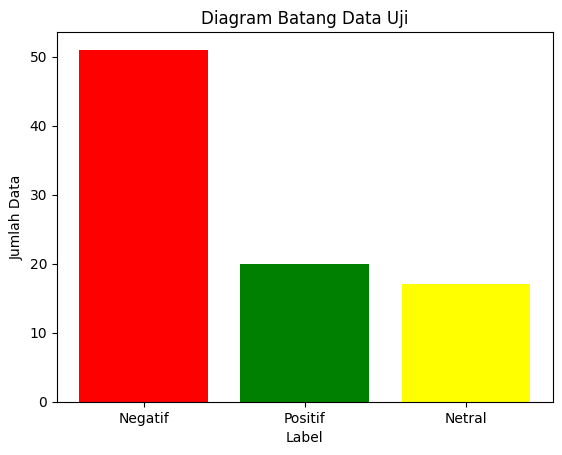

In [45]:
# Visualisasi dengan diagram batang
# Hitung frekuensi setiap kategori label
label_counts = y_test.value_counts()

# Buat diagram batang
plt.bar(['Negatif', 'Positif', 'Netral'], label_counts, color=['red', 'green', 'yellow'])

# Tambahkan label dan judul
plt.xlabel('Label')
plt.ylabel('Jumlah Data')
plt.title('Diagram Batang Data Uji')

# Tampilkan diagram
plt.show()

In [46]:
# Ekstraksi fitur menggunakan CountVectorizer
vectorizer = CountVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

# Training

In [47]:
# Model Naive Bayes
naive_bayes_classifier = MultinomialNB()
naive_bayes_classifier.fit(X_train_vectorized, y_train)
y_pred_nb = naive_bayes_classifier.predict(X_test_vectorized)

# Confusion Matrix, Recall, Precision, F1 Score untuk Naive Bayes
conf_matrix_nb = confusion_matrix(y_test, y_pred_nb)
report_nb = classification_report(y_test, y_pred_nb)

print("Confusion Matrix Naive Bayes:")
print(conf_matrix_nb)
print("\nClassification Report Naive Bayes:")
print(report_nb)

Confusion Matrix Naive Bayes:
[[45  2  4]
 [14  3  0]
 [16  0  4]]

Classification Report Naive Bayes:
              precision    recall  f1-score   support

     negatif       0.60      0.88      0.71        51
      netral       0.60      0.18      0.27        17
     positif       0.50      0.20      0.29        20

    accuracy                           0.59        88
   macro avg       0.57      0.42      0.42        88
weighted avg       0.58      0.59      0.53        88



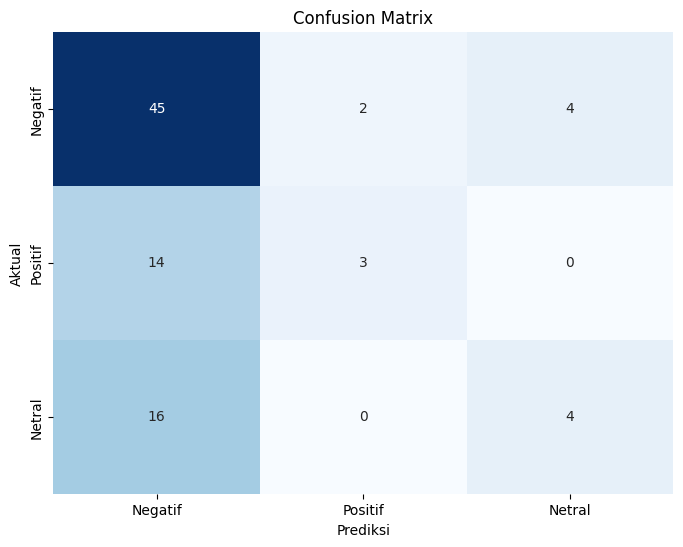

In [49]:
# Visualisasi confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_nb, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Negatif", "Positif","Netral"],
            yticklabels=["Negatif", "Positif", "Netral"])
plt.title("Confusion Matrix")
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.show()

In [50]:
# Menambahkan kolom prediksi dan label aktual ke DataFrame uji
df_uji = pd.DataFrame({'Text': X_test, 'Label Aktual': y_test, 'Label Prediksi': y_pred_nb})
df_uji.head(50)

,Text,Label Aktual,Label Prediksi
92,bangsa bangladesh diaspora sbg rohingya suruh ...,negatif,negatif
365,ngeri ras kelompok ras ungsi rohingya ngeri ke...,negatif,negatif
254,oh bobon ras xenophobic masak rohingya plus ka...,positif,negatif
418,maaf pacar rohingya,negatif,negatif
203,nang sih nang gara inget anak palestina gmn iy...,negatif,negatif
169,presiden rohingya wkwkw,positif,positif
12,rohingya zionis,netral,negatif
423,nahh bela rohingya terima rohingya indo logika...,negatif,negatif
86,wkwkwk lucu bgttt,positif,positif
126,yaelahhh canda isu rohingya,negatif,negatif


In [53]:
joblib.dump(vectorizer, 'vectorized_VieriAskaJuneioSembiring.pkl')

['vectorized_VieriAskaJuneioSembiring.pkl']

In [54]:
joblib.dump(naive_bayes_classifier, 'model_VieriAskaJuneioSembiring.pkl')

['model_VieriAskaJuneioSembiring.pkl']